In [1]:
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Importing NumPy (Numerical Python) which is a library consisting of multidimensional array objects and a collection of routines for processing those arrays. It also gives an alias to the library.
import numpy as np

% matplotlib inline
np.random.seed(2017)

from keras import regularizers
from keras.models import Model
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dropout, GlobalAveragePooling2D, Input, Dense
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.callbacks import Callback
# Importing the callbacks of Keras.
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar10
from keras import backend as K

Using TensorFlow backend.


In [2]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
BATCH_SIZE = 128 #@param ["512", "256", "128"] {type:"raw"}
MOMENTUM = 0.9 #@param ["0.9", "0.95", "0.975"] {type:"raw"}
WEIGHT_DECAY = 5e-4 #@param ["0.000125", "0.00025", "0.0005", "5e-4"] {type:"raw"}
LEARNING_RATE = 0.1 #@param ["0.4", "0.2", "0.1"] {type:"raw"}
EPOCHS = 300 #@param {type:"slider", min:0, max:300, step:1}
WARMUP = 5 #@param {type:"slider", min:0, max:24, step:1}

In [4]:
# CIFAR10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Importing CIFAR10 dataset from Keras.
from keras.datasets import cifar10

# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(validation_iterator, test_y, model):
    result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def get_cutout_eraser_and_padcrop(p=0.5, s_l=0.05, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True, random_crop_size=(32, 32), padding_pixels=4):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
     
    def random_crop(input_image):
          # Note: image_data_format is 'channel_last'
          assert input_image.shape[2] == 3
          
          #Pad by 4 pixels
          img = cv2.copyMakeBorder(input_image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_REPLICATE)
          
          height, width = img.shape[0], img.shape[1]
          dy, dx = random_crop_size
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)
          return img[y:(y+dy), x:(x+dx), :]
        
    def preproc_image(input_image):
      #return eraser
      return eraser(random_crop(input_image))

    return preproc_image
      
        

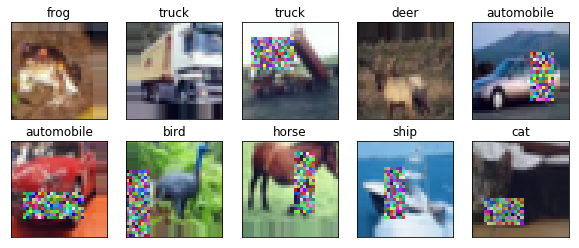

In [12]:
datagen = ImageDataGenerator(
   featurewise_center=True,
   featurewise_std_normalization=True,
   horizontal_flip=True,                 # randomly flip images                                     
   preprocessing_function=get_cutout_eraser_and_padcrop(p=0.75, s_l=0.05, s_h=0.2, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=100,shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

In [0]:
datagen_validation = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,)
datagen.mean = np.array([0.4914, 0.4822, 0.4465], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.std = np.array([0.2023, 0.1994, 0.2010], dtype=np.float32).reshape((1,1,3)) # ordering: [R, G, B]
datagen.fit(X_train)
datagen_validation.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=256,shuffle=True)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=512,shuffle=True)

In [0]:
def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


In [0]:
def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

In [0]:
def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

In [0]:
def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


In [0]:
def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=3)(input)
    return Activation("relu")(norm)

In [0]:
input_shape=(32, 32, 3)
num_outputs = 10

In [21]:
#Define ResNet18 model
input = Input(shape=input_shape)
conv1 = _conv_bn_relu(filters=32, kernel_size=(3, 3), strides=(1, 1))(input)
#pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

block = conv1

#B1
filters = 32
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=True)(block)

#B2
filters = 64
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

#B3
filters = 128
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

#B4
filters = 256
block = _residual_block(basic_block, filters=filters, repetitions=2, is_first_layer=False)(block)

# Last activation
block = _bn_relu(block)

# Classifier block
pool = GlobalAveragePooling2D()(block)
dense = Dense(units=num_outputs, kernel_initializer="he_normal",
              activation="softmax")(pool)

model = Model(inputs=input, outputs=dense)

W0802 23:18:14.763872 140655597586304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 23:18:14.809560 140655597586304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 23:18:14.818019 140655597586304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0802 23:18:14.877016 140655597586304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0802 23:18:14.878256

In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [23]:
!wget "https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/clr.py"

--2019-08-02 23:18:21--  https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/clr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7928 (7.7K) [text/plain]
Saving to: ‘clr.py’

clr.py              100%[===================>]   7.74K  --.-KB/s    in 0s      

2019-08-02 23:18:21 (58.5 MB/s) - ‘clr.py’ saved [7928/7928]



In [24]:
!wget "https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/lr_finder.py"

--2019-08-02 23:18:24--  https://raw.githubusercontent.com/SomaKorada07/EIP/master/utils/lr_finder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14968 (15K) [text/plain]
Saving to: ‘lr_finder.py’

lr_finder.py        100%[===================>]  14.62K  --.-KB/s    in 0.01s   

2019-08-02 23:18:24 (1.19 MB/s) - ‘lr_finder.py’ saved [14968/14968]



In [0]:
from lr_finder import LRFinder

In [0]:
nb_epoch = 1

weights_file = 'weights/model.h5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')

W0802 23:18:25.896939 140655597586304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



weights/losses.npy and weights/lrs.npy could not be found at directory : {weights/}


W0802 23:18:26.392425 140655597586304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 2.3883 - acc: 0.2946 - LRFinder: val_loss: 3.8408 - lr = 0.00995128 
 - LRFinder: val_loss: 4.0175 - lr = 0.00997564 
390/390 [==============================] - 140s 360ms/step - loss: 2.3877 - acc: 0.2947 - val_loss: 3.8840 - val_acc: 0.1956
	LR Finder : Saved the losses and learning rate values in path : {weights/}


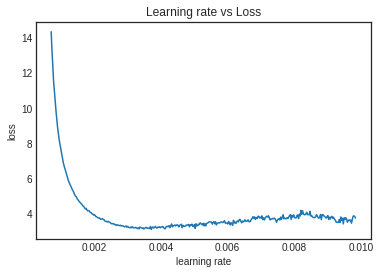

10000/10000 [==============================] - 3s 313us/step
loss : 3.8840
acc : 0.1956


In [27]:
# Exponential lr finder
# USE THIS FOR A LARGE RANGE SEARCH
# Uncomment the validation_data flag to reduce speed but get a better idea of the learning rate
#lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=1e-3, maximum_lr=10.,
                     #lr_scale='exp',
                     #validation_data=(X_test, Y_test),  # use the validation data for losses
                     #validation_sample_rate=5,
                     #save_dir='weights/', verbose=True)

# Linear lr finder
# USE THIS FOR A CLOSE SEARCH
# Uncomment the validation_data flag to reduce speed but get a better idea of the learning rate
lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=5e-4, maximum_lr=1e-2,
                      lr_scale='linear',
                      validation_data=(X_test, y_test),  # use the validation data for losses
                      validation_sample_rate=5,
                      save_dir='weights/', verbose=True)


# plot the previous values if present
LRFinder.plot_schedule_from_file('weights/', clip_beginning=10, clip_endding=5)

optimizer = SGD(lr=0.1, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                        steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1,
                        callbacks=[lr_finder, model_checkpoint])

lr_finder.plot_schedule(clip_beginning=10, clip_endding=5)

scores = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
for score, metric_name in zip(scores, model.metrics_names):
    print("%s : %0.4f" % (metric_name, score))

#BEST LR IS 0.0018

Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 2.0162 - acc: 0.4374 - LRFinder: val_loss: 3.2863 - lr = 0.00995795 
 - LRFinder: val_loss: 3.3411 - lr = 0.00997897 
390/390 [==============================] - 139s 357ms/step - loss: 2.0158 - acc: 0.4375 - val_loss: 3.4034 - val_acc: 0.1580
	LR Finder : Saved the losses and learning rate values in path : {weights/momentum/momentum-0.9/}
Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 1.8416 - acc: 0.5003 - LRFinder: val_loss: 3.5110 - lr = 0.00995795 
 - LRFinder: val_loss: 3.5790 - lr = 0.00997897 
390/390 [==============================] - 139s 357ms/step - loss: 1.8413 - acc: 0.5002 - val_loss: 3.5282 - val_acc: 0.1593
	LR Finder : Saved the losses and learning rate values in path : {weights/momentum/momentum-0.95/}
Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 1.7038 - acc: 0.5515 - LRFinder: val_loss: 4.9296 - lr = 0.00995795 
 - LRFinder: val_loss: 4.6108 - lr = 0.00

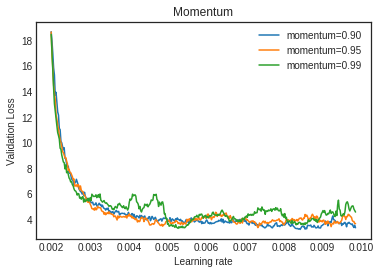

In [28]:
MOMENTUMS = [0.9, 0.95, 0.99]
nb_epoch = 1

for momentum in MOMENTUMS:
#     # Learning rate range obtained from `find_lr_schedule.py`
#     # NOTE : Minimum is 10x smaller than the max found above !
#     # NOTE : It is preferable to use the validation data here to get a correct value
      lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=0.0018, maximum_lr=1e-2,
                          validation_data=(X_test, Y_test),
                          validation_sample_rate=5,
                          lr_scale='linear', save_dir='weights/momentum/momentum-%s/' % str(momentum),
                          verbose=True)

#     # set the weight_decay here !
#     # lr doesnt matter as it will be over written by the callback
      optimizer = SGD(lr=0.0018, momentum=momentum, nesterov=True)
      model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#         # Fit the model on the batches generated by datagen.flow().
      model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                             validation_data=(X_test, Y_test),
                             epochs=nb_epoch, verbose=1,
                             callbacks=[lr_finder])

# from plot we see, the model isnt impacted by the weight_decay very much at all
# so we can use any of them.

for momentum in MOMENTUMS:
    directory = 'weights/momentum/momentum-%s/' % str(momentum)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='momentum=%0.2f' % momentum)

plt.title("Momentum")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

#BEST MOMENTUM IS 0.9

Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 1.4890 - acc: 0.6276 - LRFinder: val_loss: 4.2583 - lr = 0.00995795 
 - LRFinder: val_loss: 4.0620 - lr = 0.00997897 
390/390 [==============================] - 140s 358ms/step - loss: 1.4890 - acc: 0.6275 - val_loss: 4.1126 - val_acc: 0.1741
	LR Finder : Saved the losses and learning rate values in path : {weights/weight_decay/weight_decay-1e-07/}
Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 1.4181 - acc: 0.6524 - LRFinder: val_loss: 4.0927 - lr = 0.00995795 
 - LRFinder: val_loss: 4.0950 - lr = 0.00997897 
390/390 [==============================] - 140s 358ms/step - loss: 1.4184 - acc: 0.6524 - val_loss: 4.1710 - val_acc: 0.2003
	LR Finder : Saved the losses and learning rate values in path : {weights/weight_decay/weight_decay-3e-07/}
Epoch 1/1
389/390 [============================>.] - ETA: 0s - loss: 1.3778 - acc: 0.6661 - LRFinder: val_loss: 3.9054 - lr = 0.00995795 
 - LRFinder: val_loss:

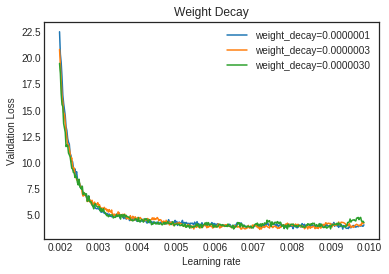

In [29]:
# INITIAL WEIGHT DECAY FACTORS
# WEIGHT_DECAY_FACTORS = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

# FINEGRAINED WEIGHT DECAY FACTORS
WEIGHT_DECAY_FACTORS = [1e-7, 3e-7, 3e-6]

for weight_decay in WEIGHT_DECAY_FACTORS:
     lr_finder = LRFinder(n_train, BATCH_SIZE, minimum_lr=0.0018, maximum_lr=1e-2,
                          validation_data=(X_test, Y_test),
                          validation_sample_rate=5,
                          lr_scale='linear', save_dir='weights/weight_decay/weight_decay-%s/' % str(weight_decay),
                          verbose=True)

#     # set the weight_decay here !
#     # lr doesnt matter as it will be over written by the callback
     optimizer = SGD(lr=0.0038, momentum=0.9, nesterov=True)
     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#
#         # Fit the model on the batches generated by datagen.flow().
     model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True),
                             steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                             validation_data=(X_test, Y_test),
                             epochs=nb_epoch, verbose=1,
                             callbacks=[lr_finder])

# from plot we see, the model isnt impacted by the weight_decay very much at all
# so we can use any of them.

for weight_decay in WEIGHT_DECAY_FACTORS:
    directory = 'weights/weight_decay/weight_decay-%s/' % str(weight_decay)

    losses, lrs = LRFinder.restore_schedule_from_dir(directory, 10, 5)
    plt.plot(lrs, losses, label='weight_decay=%0.7f' % weight_decay)

plt.title("Weight Decay")
plt.xlabel("Learning rate")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

#BEST DECAY IS 0.0000003

In [0]:
sgd = SGD(lr=0.0018, decay=0.000003, momentum=0.9, nesterov=True)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Specifying the path to store the weights
filepath="/content/gdrive/My Drive/Assignment13_v3:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='max')

In [0]:
from clr import OneCycleLR

lr_manager = OneCycleLR(epochs=EPOCHS, batch_size=BATCH_SIZE, samples=n_train, steps=len(train_iterator), max_lr=0.0018,
                        end_percentage=0.1, scale=100,
                        maximum_momentum=0.95, minimum_momentum=0.9)

callbacks = [checkpoint, lr_manager]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=196, validation_data=<keras_pre..., validation_steps=20, verbose=1, callbacks=[<keras.ca..., epochs=300)`
  
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


Epoch 1/300
  2/196 [..............................] - ETA: 7:30 - loss: 1.3070 - acc: 0.6738 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.327911). Check your callbacks.
  % delta_t_median)


196/196 [==============================] - 52s 266ms/step - loss: 1.3538 - acc: 0.6755 - val_loss: 1.2599 - val_acc: 0.7089
 - lr: 0.00003 - momentum: 0.95 
Epoch 2/300
196/196 [==============================] - 46s 237ms/step - loss: 1.3361 - acc: 0.6777 - val_loss: 1.2523 - val_acc: 0.7116
 - lr: 0.00004 - momentum: 0.95 
Epoch 3/300
196/196 [==============================] - 46s 237ms/step - loss: 1.3287 - acc: 0.6804 - val_loss: 1.2470 - val_acc: 0.7132
 - lr: 0.00006 - momentum: 0.95 
Epoch 4/300
196/196 [==============================] - 47s 237ms/step - loss: 1.3243 - acc: 0.6842 - val_loss: 1.2431 - val_acc: 0.7152
 - lr: 0.00007 - momentum: 0.95 
Epoch 5/300
196/196 [==============================] - 46s 237ms/step - loss: 1.3204 - acc: 0.6850 - val_loss: 1.2395 - val_acc: 0.7146
 - lr: 0.00008 - momentum: 0.95 
Epoch 6/300
196/196 [==============================] - 46s 236ms/step - loss: 1.3164 - acc: 0.6876 - val_loss: 1.2367 - val_acc: 0.7169
 - lr: 0.00010 - momentum: 0.95

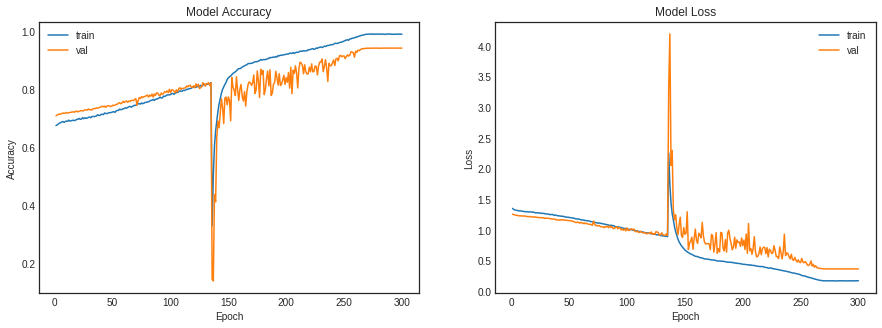

In [33]:
# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(train_iterator,
                                 steps_per_epoch = len(train_iterator), nb_epoch = EPOCHS, 
                                 validation_data = validation_iterator, 
                                 validation_steps = len(validation_iterator),
                                 verbose=1, callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [34]:
# compute test accuracy
result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
print(result)

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:651: DeprecationWarning: `wait_time` is not used anymore.
  DeprecationWarning)


[0.3466647204875946, 0.9476]


#Best Accuracy - 0.9428

Epoch **294**/300
196/196 [==============================] - 47s 239ms/step - loss: 0.1745 - acc: 0.9902 - val_loss: 0.3676 - val_acc: **0.9428**
 - lr: 0.00000 - momentum: 0.95

#Reached 90% val accuracy at
Epoch **231**/300
196/196 [==============================] - 47s 239ms/step - loss: 0.3572 - acc: 0.9445 - val_loss: 0.5368 - val_acc: **0.9050**
 - lr: 0.05202 - momentum: 0.94

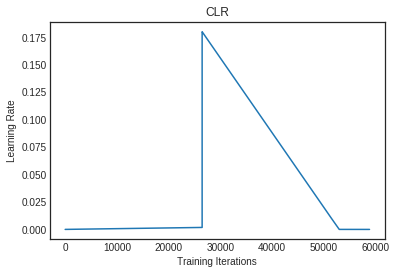

In [35]:
# Plot Learning Rate
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR")
plt.plot(lr_manager.history['lr'])
plt.show()

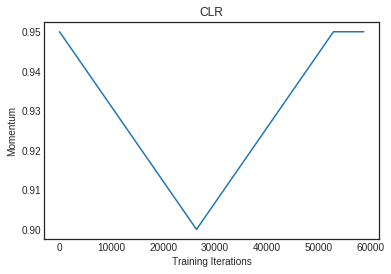

In [36]:
# Plot momentum
plt.xlabel('Training Iterations')
plt.ylabel('Momentum')
plt.title("CLR")
plt.plot(lr_manager.history['momentum'])
plt.show()